In [34]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed


In [35]:
# Set random seed for reproducibility
np.random.seed(42)

# Constants
K = 10  # Number of arms (actions) in the bandit problem
STEPS = 1000  # Number of steps (iterations) for each run
RUNS = 2000  # Number of independent runs for each parameter setting

# Parameter labels for x-axis
PARAM_LABELS = ['1/128', '1/64', '1/32', '1/16', '1/8', '1/4', '1/2', '1', '2', '4']

# Define parameter values for each algorithm
# Epsilon-Greedy: ε values from 1/128 to 1/4
PARAM_VALUES_EPS = [1/128, 1/64, 1/32, 1/16, 1/8, 1/4]

# Gradient Bandit: α values from 1/32 to 4
PARAM_VALUES_ALPHA = [1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4]

# UCB: c values from 1/16 to 4
PARAM_VALUES_C = [1/16, 1/8, 1/4, 1/2, 1, 2, 4]

# Optimistic Initialization: Q₀ values from 1/4 to 4
PARAM_VALUES_Q0 = [1/4, 1/2, 1, 2, 4]


In [36]:
class BanditEnvironment:
    """Class representing a k-armed bandit environment."""
    def __init__(self, k=K):
        # True action-value distribution for each arm (mean of rewards)
        self.k = k
        self.q_true = np.random.normal(0, 1, k)
        self.optimal_action = np.argmax(self.q_true)  # Identify the optimal action
    
    def step(self, action):
        # Simulate reward for the selected action
        reward = np.random.normal(self.q_true[action], 1)
        return reward
    

In [37]:
class Agent:
    """Base class for agents."""
    def __init__(self, k=K):
        self.k = k  # Number of actions
    
    def select_action(self):
        raise NotImplementedError  # To be implemented by subclasses
    
    def update(self, action, reward):
        raise NotImplementedError  # To be implemented by subclasses
    

In [38]:
class EpsilonGreedyAgent(Agent):
    """Epsilon-Greedy Agent."""
    def __init__(self, epsilon, k=K):
        super().__init__(k)
        self.epsilon = epsilon  # Exploration probability
        self.q_estimates = np.zeros(k)  # Action-value estimates
        self.action_counts = np.zeros(k)  # Count of times each action was selected
    
    def select_action(self):
        # Epsilon-greedy action selection: explore with ε probability, otherwise exploit
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.k)  # Explore (random action)
        else:
            return np.argmax(self.q_estimates)  # Exploit (choose the best known action)
    
    def update(self, action, reward):
        # Update action-value estimates using incremental formula
        self.action_counts[action] += 1
        self.q_estimates[action] += (reward - self.q_estimates[action]) / self.action_counts[action]


In [39]:
class GradientBanditAgent(Agent):
    """Gradient Bandit Agent."""
    def __init__(self, alpha, k=K):
        super().__init__(k)
        self.alpha = alpha  # Step size for preference update
        self.preferences = np.zeros(k)  # Preference values for each action
    
    def select_action(self):
        # Softmax action selection based on preferences
        exp_preferences = np.exp(self.preferences - np.max(self.preferences))  # Stabilize softmax computation
        self.action_probabilities = exp_preferences / np.sum(exp_preferences)  # Probability of selecting each action
        action = np.random.choice(self.k, p=self.action_probabilities)  # Choose action based on probabilities
        return action
    
    def update(self, action, reward):
        # Update preferences based on reward received
        baseline = 0  # Baseline (mean reward) set to 0
        one_hot = np.zeros(self.k)
        one_hot[action] = 1  # One-hot encoding of the selected action
        self.preferences += self.alpha * (reward - baseline) * (one_hot - self.action_probabilities)  # Update rule
        

In [40]:
class UCBAgent(Agent):
    """Upper Confidence Bound Agent."""
    def __init__(self, c, k=K):
        super().__init__(k)
        self.c = c  # Exploration parameter
        self.q_estimates = np.zeros(k)  # Action-value estimates
        self.action_counts = np.zeros(k)  # Count of times each action was selected
        self.total_counts = 0  # Total number of actions selected so far
    
    def select_action(self):
        # UCB action selection: choose action with highest upper confidence bound
        self.total_counts += 1
        ucb_values = np.zeros(self.k)
        for action in range(self.k):
            if self.action_counts[action] == 0:
                ucb_values[action] = float('inf')  # Assign infinite value to untried actions
            else:
                ucb_values[action] = self.q_estimates[action] + \
                    self.c * np.sqrt(np.log(self.total_counts) / self.action_counts[action])
        return np.argmax(ucb_values)  # Choose action with highest UCB value
    
    def update(self, action, reward):
        # Update action-value estimates
        self.action_counts[action] += 1
        self.q_estimates[action] += (reward - self.q_estimates[action]) / self.action_counts[action]
        

In [41]:
class OptimisticInitializationAgent(Agent):
    """Greedy Agent with Optimistic Initialization."""
    def __init__(self, q0, alpha=0.1, k=K):
        super().__init__(k)
        self.q_estimates = np.ones(k) * q0  # Optimistic initial estimates
        self.alpha = alpha  # Step size
    
    def select_action(self):
        # Greedy action selection based on optimistic initial values
        return np.argmax(self.q_estimates)
    
    def update(self, action, reward):
        # Update action-value estimates using constant step-size α
        self.q_estimates[action] += self.alpha * (reward - self.q_estimates[action])
        

In [42]:
def run_agent(agent_class, param, steps=STEPS):
    # Simulate agent's performance over a fixed number of steps
    rewards = np.zeros(steps)
    agent = agent_class(param)  # Initialize agent with the given parameter
    env = BanditEnvironment()  # Initialize the bandit environment
    for step in range(steps):
        action = agent.select_action()  # Agent selects action
        reward = env.step(action)  # Environment returns reward
        agent.update(action, reward)  # Agent updates based on the reward
        rewards[step] = reward
    average_reward = np.mean(rewards)  # Calculate average reward over steps
    return average_reward


In [43]:
def parallel_run(agent_class, params, runs=RUNS, steps=STEPS, n_jobs=-1):
    # Run simulations in parallel for multiple parameters and return average rewards
    results = []
    for param in params:
        rewards = Parallel(n_jobs=n_jobs)(
            delayed(run_agent)(agent_class, param, steps) for _ in range(runs)
        )
        average_reward = np.mean(rewards)
        results.append(average_reward)
    return results


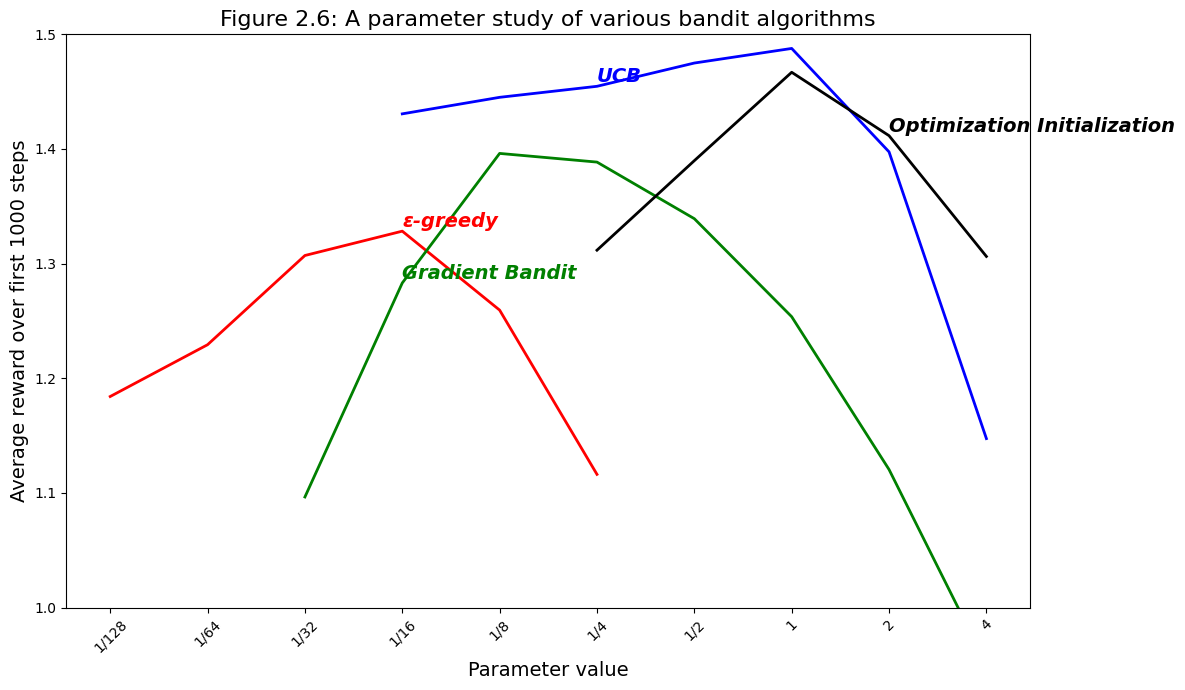

In [44]:
def main():
    """
    Main function to run simulations and plot the results.
    """
    # Run simulations for each algorithm with adjusted parameter values
    avg_rewards_eps = parallel_run(EpsilonGreedyAgent, PARAM_VALUES_EPS)
    avg_rewards_alpha = parallel_run(GradientBanditAgent, PARAM_VALUES_ALPHA)
    avg_rewards_c = parallel_run(UCBAgent, PARAM_VALUES_C)
    avg_rewards_q0 = parallel_run(OptimisticInitializationAgent, PARAM_VALUES_Q0)

    # Plotting
    plt.figure(figsize=(12, 7))

    # Plot lines without markers
    plt.plot(PARAM_VALUES_EPS, avg_rewards_eps, color='red', linewidth=2)
    plt.plot(PARAM_VALUES_ALPHA, avg_rewards_alpha, color='green', linewidth=2)
    plt.plot(PARAM_VALUES_C, avg_rewards_c, color='blue', linewidth=2)
    plt.plot(PARAM_VALUES_Q0, avg_rewards_q0, color='black', linewidth=2)

    # Since parameter values are different for each algorithm, we need to adjust x-axis ticks accordingly
    all_params = sorted(set(PARAM_VALUES_EPS + PARAM_VALUES_ALPHA + PARAM_VALUES_C + PARAM_VALUES_Q0))
    all_params_labels = [str(p) if p >= 1 else f'1/{int(1/p)}' for p in all_params]
    plt.xscale('log', base=2)  # Log scale for x-axis
    plt.xticks(all_params, all_params_labels, rotation=45)  # Label x-axis with parameter values

    plt.xlabel('Parameter value', fontsize=14)
    plt.ylabel('Average reward over first 1000 steps', fontsize=14)
    plt.title('Figure 2.6: A parameter study of various bandit algorithms', fontsize=16)
    plt.grid(False)

    # Adjust y-axis to focus on the range of interest
    plt.ylim(1.0, 1.5)

    # Inline labels
    def add_inline_label(x_values, y_values, text, color, x_pos):
        # Add text labels inline at specific points on the plot
        idx = x_values.index(x_pos)
        x = x_values[idx]
        y = y_values[idx]
        plt.text(x, y, text, color=color, fontsize=14, fontstyle='italic', fontweight='bold',
                horizontalalignment='left', verticalalignment='bottom')

    # Place inline labels at specified x-values for each algorithm
    add_inline_label(PARAM_VALUES_EPS, avg_rewards_eps, 'ε-greedy', 'red', x_pos=1/16)
    add_inline_label(PARAM_VALUES_ALPHA, avg_rewards_alpha, 'Gradient Bandit', 'green', x_pos=1/16)
    add_inline_label(PARAM_VALUES_C, avg_rewards_c, 'UCB', 'blue', x_pos=1/4)
    add_inline_label(PARAM_VALUES_Q0, avg_rewards_q0, 'Optimization Initialization', 'black', x_pos=2)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
